# Preprocess interesting timeseries

In [8]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')
last_n_percent = 0.50

def get_dom_mode(ggap, gsyn, C = 0.015, Gc = 0.1):
  all_dynamics = simulate_until_stable(
    C = C,
    Gc = Gc,
    ggap = ggap,
    gsyn = gsyn)
  n = all_dynamics.shape[0]
  last_dynamics = all_dynamics[-int(last_n_percent * n):,:]
  pca = PCA(n_components = 1)
  # Perform mean-centering before PCA
  X = last_dynamics - last_dynamics.mean(axis= 0)
  projected_X = pca.fit_transform(last_dynamics)
  return projected_X[:,0]

def preprocess_ts(ts):
  # Scale to mean 0 variance 1. We want similar looking-graphs, no matter the amplitude,
  # to be grouped together
  fft_period = get_period(ts)
  # Times 100 because the period is in seconds, but our array timescale is 0.01s for each index.
  # Times 2 because we want to see multiple periods to distinguish between focus and stable oscillation.
  ts = ts[-int(fft_period) * 100 * 2:]
  ts = TimeSeriesScalerMeanVariance().fit_transform(ts)
  # Make time series shorter for faster processing.
  # Disadvantage is that we will lose the smoothness vs sharpness info.
  ts = TimeSeriesResampler(sz=50).fit_transform(ts)
  ts = ts.reshape(-1)
  return ts

def plot_ts(ax, ts):
  times = np.arange(0, ts.shape[0] * 0.01 , 0.01)
  ax.plot(times, ts)
  
ts_simple_oscillation = get_dom_mode(ggap = 1.0, gsyn = 1.0)
ts_stable_node = get_dom_mode(ggap = 0.0, gsyn = 0.0)
ts_stable_focus = get_dom_mode(C = 0.002, Gc = 0.7, ggap = 1.0, gsyn = 1.0)
ts_nested_oscillation_mean_shift = get_dom_mode(ggap = 0.875, gsyn = 1.5)
ts_nested_oscillation_amplitude_shift = get_dom_mode(ggap = 0.0789, gsyn = 1.1842)
ts_spike = get_dom_mode(ggap = 0.1579, gsyn = 1.2632)

ts_list = \
  [
    ts_simple_oscillation,
    ts_stable_node,
    ts_stable_focus,
    ts_nested_oscillation_mean_shift,
    ts_nested_oscillation_amplitude_shift,
    ts_spike
  ]

fig, axes = plt.subplots(nrows=len(ts_list), ncols=2, figsize=(10, 3 * len(ts_list)))

for row in range(len(ts_list)):
  ts = ts_list[row]
  preprocessed_ts = preprocess_ts(ts)
  plot_ts(axes[row][0], ts)
  plot_ts(axes[row][1], preprocessed_ts)

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.002_Gc=0.7_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.875_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263


# Kmeans, euclidean metric

32.998 --> 15.936 --> 15.936 --> 


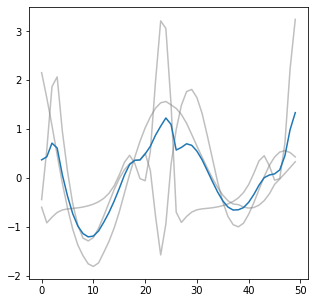

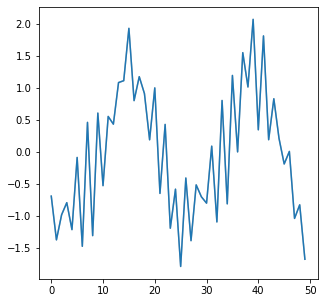

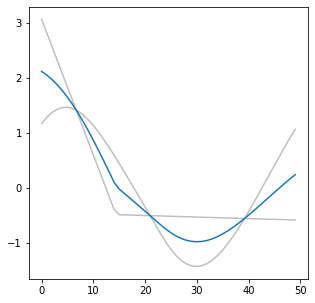

In [29]:
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

n_clusters = 3
seed = 0
np.random.seed(seed)
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)

ts_list = [
  ts_simple_oscillation,
  ts_stable_node,
  ts_stable_focus,
  ts_nested_oscillation_mean_shift,
  ts_nested_oscillation_amplitude_shift,
  ts_spike
]

preprocessed_ts_list = []
for ts in ts_list:
  preprocessed_ts_list.append(preprocess_ts(ts))
preprocessed_ts_list = np.array(preprocessed_ts_list)
cluster_labels = km.fit_predict(preprocessed_ts_list)
  
for cluster_id in range(n_clusters):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  for ts in preprocessed_ts_list[cluster_labels == cluster_id]:
    ax.plot(ts, alpha=.5, c='gray')
  ax.plot(km.cluster_centers_[cluster_id])
  